In [1]:
%load_ext autoreload 
%autoreload 2

# Exp2 Modify DCGAN to generate 128*128 images

In [2]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from networks import weights_init, Generator_64, Discriminator_64, Generator_128_v2, Discriminator_128_v2

In [3]:
# settings
dataroot = "data/celeba"
batch_size = 128
image_size = 128 #size using data aug.

ch_out = 3 
ch_noise = 100
ch_g = 64
ch_d = 64

num_epochs = 50
lr = 0.0002
beta1 = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# dataloader
train_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
print(len(train_dataset))

# networks
#net_G = Generator_64(ch_noise, ch_g, ch_out).to(device)
net_G = Generator_128_v2(ch_noise, ch_g, ch_out).to(device)
net_G.apply(weights_init)
print(net_G)

#net_D = Discriminator_64(ch_out, ch_d).to(device)
net_D = Discriminator_128_v2(ch_out, ch_d).to(device)
net_D.apply(weights_init)
print(net_D)

# loss and optimizer
criterion = nn.BCELoss()
optimizer_D = optim.Adam(net_D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(net_G.parameters(), lr=lr, betas=(beta1, 0.999))
lr_scheduler_G = optim.lr_scheduler.MultiStepLR(optimizer_D, [10,25], gamma=0.1)
lr_scheduler_D = optim.lr_scheduler.MultiStepLR(optimizer_G, [10,25], gamma=0.1)

202599
Generator_128_v2(
  (backbone): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False

In [5]:
def cv2_imwrite(path, image):
    image = np.clip(np.round(image*255),0,255)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

### Adding tricks to improve convergence
# https://github.com/soumith/ganhacks
# adding soft label and label noise
def train_one_epoch(epoch, dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device):
    G_losses = []
    D_losses = []
    for iteration, data in enumerate(dataloader, 0):
        ### Update D
        net_G.train()
        net_D.train()
        #data
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label_tmp = torch.rand((batch_size,))*0.5+0.7 #use soft label
        
        noise = torch.randn(batch_size, ch_noise, 1, 1, device=device) #(b,c,1,1)
        fake_data = net_G(noise)
        #fake_label = torch.zeros((batch_size,), dtype=torch.float, device=device)
        fake_label_tmp = torch.rand((batch_size,))*0.3
        
        if torch.rand(1) < 0.05: #add label noise
            real_label = fake_label_tmp.to(device)
            fake_label = real_label_tmp.to(device)
        else:
            real_label = real_label_tmp.to(device)
            fake_label = fake_label_tmp.to(device)
        
        #forward
        real_output = net_D(real_data).view(-1)
        fake_output = net_D(fake_data.detach()).view(-1)
        real_loss_D = criterion(real_output, real_label)
        fake_loss_D = criterion(fake_output, fake_label)
        loss_D = real_loss_D + fake_loss_D
        
        #backward
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        

        ### Update G
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label = torch.rand((batch_size,))*0.5+0.7
        real_label = real_label.to(device)
        fake_output_G = net_D(fake_data).view(-1)
        loss_G = criterion(fake_output_G, real_label)
        
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        
        # logs
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        if iteration % 50 == 0:
            print('[{:d}/{:d}] Iter:{:d}  Loss_D={:.4f} Loss_G={:.4f} D(x)={:.4f} D(G(z))={:.4f}, {:.4f}'.format(
                  epoch, num_epochs, iteration+1, loss_D.item(), loss_G.item(), real_output.mean().item(), fake_output.mean().item(), fake_output_G.mean().item()))
        
        # test
        if (iteration == len(dataloader)//2) or (iteration == len(dataloader)-1):
            net_G.eval()
            net_D.eval()
            with torch.no_grad():
                fake_images = net_G(fixed_noise).detach().cpu()
            fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
            #print(fake_images)
            cv2_imwrite('./fig_exp2/epoch{}Iter{}.png'.format(epoch, iteration), fake_images.numpy())
    return G_losses, D_losses


In [6]:
# Training
G_losses = []
D_losses = []
fixed_noise = torch.randn(64, ch_noise, 1, 1, device=device)
# For each epoch
for epoch in range(num_epochs):
    g,d = train_one_epoch(epoch, train_dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device)
    G_losses += g
    D_losses += d
    lr_scheduler_G.step()
    lr_scheduler_D.step()

[0/50] Iter:1  Loss_D=2.1579 Loss_G=0.1950 D(x)=0.3157 D(G(z))=0.2077, 0.9465
[0/50] Iter:51  Loss_D=7.3013 Loss_G=39.7934 D(x)=0.9477 D(G(z))=0.0000, 0.0000
[0/50] Iter:101  Loss_D=7.3054 Loss_G=38.8603 D(x)=0.9751 D(G(z))=0.0000, 0.0000
[0/50] Iter:151  Loss_D=6.4653 Loss_G=37.6348 D(x)=0.9282 D(G(z))=0.0000, 0.0000
[0/50] Iter:201  Loss_D=5.9524 Loss_G=34.2849 D(x)=0.9888 D(G(z))=0.0000, 0.0000
[0/50] Iter:251  Loss_D=9.1941 Loss_G=0.4207 D(x)=0.9477 D(G(z))=1.0000, 1.0000
[0/50] Iter:301  Loss_D=1.9049 Loss_G=9.2599 D(x)=0.8898 D(G(z))=0.8295, 0.0001
[0/50] Iter:351  Loss_D=0.7680 Loss_G=2.4016 D(x)=0.8684 D(G(z))=0.2999, 0.0822
[0/50] Iter:401  Loss_D=1.0029 Loss_G=1.7429 D(x)=0.8121 D(G(z))=0.3744, 0.2113
[0/50] Iter:451  Loss_D=1.1682 Loss_G=1.4548 D(x)=0.7102 D(G(z))=0.3090, 0.2411
[0/50] Iter:501  Loss_D=1.0185 Loss_G=0.6402 D(x)=0.6622 D(G(z))=0.2499, 0.5791
[0/50] Iter:551  Loss_D=1.0963 Loss_G=1.6079 D(x)=0.7345 D(G(z))=0.4275, 0.2119
[0/50] Iter:601  Loss_D=1.0536 Loss_G=1

[3/50] Iter:351  Loss_D=1.2408 Loss_G=1.9371 D(x)=0.7924 D(G(z))=0.5612, 0.1535
[3/50] Iter:401  Loss_D=1.0508 Loss_G=1.3173 D(x)=0.7381 D(G(z))=0.4361, 0.2701
[3/50] Iter:451  Loss_D=1.1449 Loss_G=0.7928 D(x)=0.5634 D(G(z))=0.3046, 0.4699
[3/50] Iter:501  Loss_D=1.2760 Loss_G=0.5414 D(x)=0.4788 D(G(z))=0.2005, 0.6203
[3/50] Iter:551  Loss_D=1.1866 Loss_G=1.9385 D(x)=0.7831 D(G(z))=0.5401, 0.1566
[3/50] Iter:601  Loss_D=1.0610 Loss_G=1.1587 D(x)=0.7214 D(G(z))=0.4191, 0.3225
[3/50] Iter:651  Loss_D=1.2294 Loss_G=0.7374 D(x)=0.5394 D(G(z))=0.2456, 0.5176
[3/50] Iter:701  Loss_D=1.0525 Loss_G=1.2504 D(x)=0.6783 D(G(z))=0.3449, 0.2961
[3/50] Iter:751  Loss_D=1.1174 Loss_G=1.2429 D(x)=0.6844 D(G(z))=0.4284, 0.2936
[3/50] Iter:801  Loss_D=2.2734 Loss_G=0.9599 D(x)=0.7315 D(G(z))=0.4318, 0.4243
[3/50] Iter:851  Loss_D=1.0326 Loss_G=1.3629 D(x)=0.7422 D(G(z))=0.4070, 0.2643
[3/50] Iter:901  Loss_D=1.3856 Loss_G=2.5653 D(x)=0.8812 D(G(z))=0.6533, 0.0821
[3/50] Iter:951  Loss_D=1.1679 Loss_G=0.

[6/50] Iter:701  Loss_D=0.9593 Loss_G=1.6890 D(x)=0.8009 D(G(z))=0.3869, 0.1836
[6/50] Iter:751  Loss_D=2.5903 Loss_G=0.8065 D(x)=0.7270 D(G(z))=0.2937, 0.4576
[6/50] Iter:801  Loss_D=1.0455 Loss_G=2.5563 D(x)=0.8158 D(G(z))=0.4747, 0.0766
[6/50] Iter:851  Loss_D=1.1380 Loss_G=2.3860 D(x)=0.9088 D(G(z))=0.5739, 0.0896
[6/50] Iter:901  Loss_D=1.5541 Loss_G=0.8404 D(x)=0.5413 D(G(z))=0.5029, 0.4586
[6/50] Iter:951  Loss_D=0.8253 Loss_G=1.6608 D(x)=0.7866 D(G(z))=0.3030, 0.1927
[6/50] Iter:1001  Loss_D=0.9789 Loss_G=1.0327 D(x)=0.6592 D(G(z))=0.1861, 0.3724
[6/50] Iter:1051  Loss_D=1.2100 Loss_G=0.6545 D(x)=0.5145 D(G(z))=0.1427, 0.5645
[6/50] Iter:1101  Loss_D=1.0011 Loss_G=1.3723 D(x)=0.7713 D(G(z))=0.4383, 0.2574
[6/50] Iter:1151  Loss_D=1.0437 Loss_G=2.7825 D(x)=0.8536 D(G(z))=0.5009, 0.0607
[6/50] Iter:1201  Loss_D=0.9208 Loss_G=1.0445 D(x)=0.6694 D(G(z))=0.2163, 0.3617
[6/50] Iter:1251  Loss_D=0.9547 Loss_G=1.1683 D(x)=0.6712 D(G(z))=0.2563, 0.3210
[6/50] Iter:1301  Loss_D=2.5770 Lo

[9/50] Iter:1051  Loss_D=0.9180 Loss_G=1.1343 D(x)=0.7140 D(G(z))=0.2948, 0.3348
[9/50] Iter:1101  Loss_D=1.0964 Loss_G=1.5700 D(x)=0.7434 D(G(z))=0.4751, 0.2133
[9/50] Iter:1151  Loss_D=1.0115 Loss_G=1.6245 D(x)=0.7440 D(G(z))=0.3858, 0.1999
[9/50] Iter:1201  Loss_D=0.8998 Loss_G=1.5509 D(x)=0.7944 D(G(z))=0.3322, 0.2183
[9/50] Iter:1251  Loss_D=1.1097 Loss_G=1.0802 D(x)=0.5609 D(G(z))=0.1190, 0.3532
[9/50] Iter:1301  Loss_D=0.9849 Loss_G=0.8009 D(x)=0.6538 D(G(z))=0.2514, 0.4668
[9/50] Iter:1351  Loss_D=0.8508 Loss_G=1.0880 D(x)=0.7377 D(G(z))=0.2107, 0.3415
[9/50] Iter:1401  Loss_D=0.9586 Loss_G=1.1656 D(x)=0.6945 D(G(z))=0.3185, 0.3308
[9/50] Iter:1451  Loss_D=1.1286 Loss_G=0.9180 D(x)=0.6690 D(G(z))=0.4238, 0.4099
[9/50] Iter:1501  Loss_D=1.0832 Loss_G=1.8137 D(x)=0.8201 D(G(z))=0.5029, 0.1570
[9/50] Iter:1551  Loss_D=0.9068 Loss_G=1.3304 D(x)=0.7162 D(G(z))=0.2439, 0.2763
[10/50] Iter:1  Loss_D=1.3106 Loss_G=0.6777 D(x)=0.7933 D(G(z))=0.5955, 0.5541
[10/50] Iter:51  Loss_D=2.5736

[12/50] Iter:1301  Loss_D=0.8484 Loss_G=1.3058 D(x)=0.7837 D(G(z))=0.2448, 0.2794
[12/50] Iter:1351  Loss_D=0.8347 Loss_G=1.3954 D(x)=0.7875 D(G(z))=0.2773, 0.2477
[12/50] Iter:1401  Loss_D=0.8236 Loss_G=1.3404 D(x)=0.8357 D(G(z))=0.2723, 0.2533
[12/50] Iter:1451  Loss_D=0.8589 Loss_G=1.2834 D(x)=0.8259 D(G(z))=0.3439, 0.2835
[12/50] Iter:1501  Loss_D=0.7605 Loss_G=1.3815 D(x)=0.8358 D(G(z))=0.2642, 0.2613
[12/50] Iter:1551  Loss_D=2.9854 Loss_G=0.9365 D(x)=0.7806 D(G(z))=0.2780, 0.4254
[13/50] Iter:1  Loss_D=0.7862 Loss_G=1.3437 D(x)=0.8230 D(G(z))=0.2745, 0.2640
[13/50] Iter:51  Loss_D=0.7326 Loss_G=1.3282 D(x)=0.8428 D(G(z))=0.2664, 0.2688
[13/50] Iter:101  Loss_D=0.7804 Loss_G=1.3486 D(x)=0.8240 D(G(z))=0.2593, 0.2693
[13/50] Iter:151  Loss_D=0.8352 Loss_G=1.4261 D(x)=0.8385 D(G(z))=0.2498, 0.2364
[13/50] Iter:201  Loss_D=0.8025 Loss_G=1.3468 D(x)=0.8294 D(G(z))=0.2254, 0.2640
[13/50] Iter:251  Loss_D=0.7685 Loss_G=1.3570 D(x)=0.8264 D(G(z))=0.2157, 0.2597
[13/50] Iter:301  Loss_D=

[15/50] Iter:1551  Loss_D=3.4534 Loss_G=1.1946 D(x)=0.8395 D(G(z))=0.2271, 0.3149
[16/50] Iter:1  Loss_D=0.7139 Loss_G=1.4068 D(x)=0.8685 D(G(z))=0.2623, 0.2467
[16/50] Iter:51  Loss_D=0.7888 Loss_G=1.4315 D(x)=0.8263 D(G(z))=0.2095, 0.2418
[16/50] Iter:101  Loss_D=0.7810 Loss_G=1.4326 D(x)=0.8599 D(G(z))=0.2852, 0.2447
[16/50] Iter:151  Loss_D=0.7653 Loss_G=1.4375 D(x)=0.8483 D(G(z))=0.2311, 0.2412
[16/50] Iter:201  Loss_D=0.7324 Loss_G=1.5487 D(x)=0.8459 D(G(z))=0.2284, 0.2240
[16/50] Iter:251  Loss_D=0.7697 Loss_G=1.6226 D(x)=0.8691 D(G(z))=0.2760, 0.2000
[16/50] Iter:301  Loss_D=0.7538 Loss_G=1.4872 D(x)=0.8537 D(G(z))=0.2480, 0.2299
[16/50] Iter:351  Loss_D=3.2893 Loss_G=1.1030 D(x)=0.8384 D(G(z))=0.2560, 0.3516
[16/50] Iter:401  Loss_D=0.6888 Loss_G=1.3415 D(x)=0.8594 D(G(z))=0.2331, 0.2627
[16/50] Iter:451  Loss_D=0.7832 Loss_G=1.5904 D(x)=0.8450 D(G(z))=0.2379, 0.2069
[16/50] Iter:501  Loss_D=0.7669 Loss_G=1.4971 D(x)=0.8544 D(G(z))=0.2131, 0.2224
[16/50] Iter:551  Loss_D=0.817

[19/50] Iter:201  Loss_D=0.6802 Loss_G=1.3989 D(x)=0.8438 D(G(z))=0.2278, 0.2508
[19/50] Iter:251  Loss_D=0.7668 Loss_G=1.4116 D(x)=0.8325 D(G(z))=0.2368, 0.2456
[19/50] Iter:301  Loss_D=0.7628 Loss_G=1.3738 D(x)=0.8473 D(G(z))=0.2697, 0.2637
[19/50] Iter:351  Loss_D=0.8340 Loss_G=1.4301 D(x)=0.7879 D(G(z))=0.2747, 0.2449
[19/50] Iter:401  Loss_D=2.9907 Loss_G=0.9816 D(x)=0.7889 D(G(z))=0.2493, 0.3909
[19/50] Iter:451  Loss_D=0.7671 Loss_G=1.3645 D(x)=0.8343 D(G(z))=0.2757, 0.2627
[19/50] Iter:501  Loss_D=0.7721 Loss_G=1.4778 D(x)=0.8526 D(G(z))=0.2930, 0.2322
[19/50] Iter:551  Loss_D=0.7902 Loss_G=1.5705 D(x)=0.8387 D(G(z))=0.2459, 0.2182
[19/50] Iter:601  Loss_D=3.2539 Loss_G=1.0641 D(x)=0.8432 D(G(z))=0.2850, 0.3684
[19/50] Iter:651  Loss_D=0.7959 Loss_G=1.4646 D(x)=0.8236 D(G(z))=0.2271, 0.2370
[19/50] Iter:701  Loss_D=0.7697 Loss_G=1.4502 D(x)=0.8572 D(G(z))=0.2224, 0.2405
[19/50] Iter:751  Loss_D=0.7153 Loss_G=1.4498 D(x)=0.8604 D(G(z))=0.2255, 0.2388
[19/50] Iter:801  Loss_D=0.8

[22/50] Iter:451  Loss_D=0.7202 Loss_G=1.3663 D(x)=0.8219 D(G(z))=0.2037, 0.2556
[22/50] Iter:501  Loss_D=0.7898 Loss_G=1.5173 D(x)=0.8708 D(G(z))=0.2597, 0.2335
[22/50] Iter:551  Loss_D=3.2432 Loss_G=0.9053 D(x)=0.8541 D(G(z))=0.2931, 0.4218
[22/50] Iter:601  Loss_D=0.8346 Loss_G=1.5432 D(x)=0.8408 D(G(z))=0.2061, 0.2214
[22/50] Iter:651  Loss_D=0.7168 Loss_G=1.3803 D(x)=0.8699 D(G(z))=0.2232, 0.2567
[22/50] Iter:701  Loss_D=0.7210 Loss_G=1.6520 D(x)=0.8840 D(G(z))=0.2220, 0.1995
[22/50] Iter:751  Loss_D=0.7504 Loss_G=1.3949 D(x)=0.8542 D(G(z))=0.2525, 0.2576
[22/50] Iter:801  Loss_D=0.7543 Loss_G=1.4305 D(x)=0.8422 D(G(z))=0.2449, 0.2455
[22/50] Iter:851  Loss_D=0.8391 Loss_G=1.4547 D(x)=0.8072 D(G(z))=0.2156, 0.2411
[22/50] Iter:901  Loss_D=0.7980 Loss_G=1.3507 D(x)=0.8511 D(G(z))=0.2848, 0.2638
[22/50] Iter:951  Loss_D=0.8541 Loss_G=1.3742 D(x)=0.8328 D(G(z))=0.2683, 0.2613
[22/50] Iter:1001  Loss_D=0.7923 Loss_G=1.4796 D(x)=0.8635 D(G(z))=0.2475, 0.2292
[22/50] Iter:1051  Loss_D=0

[25/50] Iter:701  Loss_D=0.7833 Loss_G=1.5047 D(x)=0.8558 D(G(z))=0.2319, 0.2280
[25/50] Iter:751  Loss_D=0.7781 Loss_G=1.3992 D(x)=0.8412 D(G(z))=0.2511, 0.2506
[25/50] Iter:801  Loss_D=0.7465 Loss_G=1.4108 D(x)=0.8421 D(G(z))=0.2492, 0.2496
[25/50] Iter:851  Loss_D=0.7722 Loss_G=1.4625 D(x)=0.8402 D(G(z))=0.2278, 0.2306
[25/50] Iter:901  Loss_D=0.7553 Loss_G=1.3759 D(x)=0.8588 D(G(z))=0.2660, 0.2616
[25/50] Iter:951  Loss_D=0.7187 Loss_G=1.4266 D(x)=0.8492 D(G(z))=0.2455, 0.2436
[25/50] Iter:1001  Loss_D=0.7123 Loss_G=1.3699 D(x)=0.8564 D(G(z))=0.2604, 0.2556
[25/50] Iter:1051  Loss_D=0.7952 Loss_G=1.3919 D(x)=0.8123 D(G(z))=0.2451, 0.2473
[25/50] Iter:1101  Loss_D=0.7522 Loss_G=1.4162 D(x)=0.8415 D(G(z))=0.2491, 0.2504
[25/50] Iter:1151  Loss_D=0.7850 Loss_G=1.2771 D(x)=0.8369 D(G(z))=0.2749, 0.2785
[25/50] Iter:1201  Loss_D=0.7390 Loss_G=1.4177 D(x)=0.8371 D(G(z))=0.2469, 0.2441
[25/50] Iter:1251  Loss_D=0.7755 Loss_G=1.3724 D(x)=0.8377 D(G(z))=0.2672, 0.2664
[25/50] Iter:1301  Los

[28/50] Iter:951  Loss_D=0.7317 Loss_G=1.5096 D(x)=0.8665 D(G(z))=0.2206, 0.2206
[28/50] Iter:1001  Loss_D=0.8102 Loss_G=1.4984 D(x)=0.8332 D(G(z))=0.2155, 0.2185
[28/50] Iter:1051  Loss_D=0.7233 Loss_G=1.4327 D(x)=0.8650 D(G(z))=0.2429, 0.2411
[28/50] Iter:1101  Loss_D=0.7849 Loss_G=1.4837 D(x)=0.8548 D(G(z))=0.2409, 0.2417
[28/50] Iter:1151  Loss_D=0.7459 Loss_G=1.5052 D(x)=0.8342 D(G(z))=0.2232, 0.2257
[28/50] Iter:1201  Loss_D=0.7391 Loss_G=1.4119 D(x)=0.8501 D(G(z))=0.2393, 0.2428
[28/50] Iter:1251  Loss_D=0.7141 Loss_G=1.4889 D(x)=0.8611 D(G(z))=0.2301, 0.2307
[28/50] Iter:1301  Loss_D=0.7584 Loss_G=1.4647 D(x)=0.8696 D(G(z))=0.2477, 0.2414
[28/50] Iter:1351  Loss_D=0.6656 Loss_G=1.4813 D(x)=0.8691 D(G(z))=0.2368, 0.2364
[28/50] Iter:1401  Loss_D=0.7693 Loss_G=1.4857 D(x)=0.8510 D(G(z))=0.2447, 0.2463
[28/50] Iter:1451  Loss_D=0.7408 Loss_G=1.5056 D(x)=0.8562 D(G(z))=0.2298, 0.2304
[28/50] Iter:1501  Loss_D=0.7674 Loss_G=1.5544 D(x)=0.8658 D(G(z))=0.2182, 0.2173
[28/50] Iter:1551

[31/50] Iter:1201  Loss_D=0.7439 Loss_G=1.4439 D(x)=0.8580 D(G(z))=0.2527, 0.2433
[31/50] Iter:1251  Loss_D=0.7832 Loss_G=1.4271 D(x)=0.8591 D(G(z))=0.2530, 0.2484
[31/50] Iter:1301  Loss_D=0.7405 Loss_G=1.4059 D(x)=0.8536 D(G(z))=0.2542, 0.2530
[31/50] Iter:1351  Loss_D=0.6906 Loss_G=1.5322 D(x)=0.8638 D(G(z))=0.2222, 0.2227
[31/50] Iter:1401  Loss_D=0.7704 Loss_G=1.4743 D(x)=0.8505 D(G(z))=0.2314, 0.2341
[31/50] Iter:1451  Loss_D=0.7294 Loss_G=1.5594 D(x)=0.8641 D(G(z))=0.2118, 0.2162
[31/50] Iter:1501  Loss_D=0.7938 Loss_G=1.3805 D(x)=0.8451 D(G(z))=0.2575, 0.2539
[31/50] Iter:1551  Loss_D=0.7280 Loss_G=1.4640 D(x)=0.8578 D(G(z))=0.2373, 0.2352
[32/50] Iter:1  Loss_D=0.7153 Loss_G=1.5146 D(x)=0.8575 D(G(z))=0.2256, 0.2254
[32/50] Iter:51  Loss_D=0.7504 Loss_G=1.4374 D(x)=0.8691 D(G(z))=0.2377, 0.2368
[32/50] Iter:101  Loss_D=0.7764 Loss_G=1.3930 D(x)=0.8855 D(G(z))=0.2561, 0.2488
[32/50] Iter:151  Loss_D=0.7443 Loss_G=1.4776 D(x)=0.8552 D(G(z))=0.2412, 0.2386
[32/50] Iter:201  Loss_

[34/50] Iter:1451  Loss_D=0.7581 Loss_G=1.3460 D(x)=0.8565 D(G(z))=0.2631, 0.2604
[34/50] Iter:1501  Loss_D=0.7591 Loss_G=1.4248 D(x)=0.8518 D(G(z))=0.2530, 0.2512
[34/50] Iter:1551  Loss_D=0.7572 Loss_G=1.3576 D(x)=0.8756 D(G(z))=0.2694, 0.2643
[35/50] Iter:1  Loss_D=0.7669 Loss_G=1.4449 D(x)=0.8647 D(G(z))=0.2474, 0.2406
[35/50] Iter:51  Loss_D=3.3497 Loss_G=1.3839 D(x)=0.8504 D(G(z))=0.2280, 0.2476
[35/50] Iter:101  Loss_D=0.7756 Loss_G=1.3485 D(x)=0.8501 D(G(z))=0.2737, 0.2677
[35/50] Iter:151  Loss_D=0.7405 Loss_G=1.4496 D(x)=0.8319 D(G(z))=0.2488, 0.2469
[35/50] Iter:201  Loss_D=0.8170 Loss_G=1.4922 D(x)=0.8391 D(G(z))=0.2307, 0.2329
[35/50] Iter:251  Loss_D=0.7809 Loss_G=1.3958 D(x)=0.8344 D(G(z))=0.2603, 0.2559
[35/50] Iter:301  Loss_D=0.7734 Loss_G=1.3260 D(x)=0.8424 D(G(z))=0.2763, 0.2716
[35/50] Iter:351  Loss_D=0.8115 Loss_G=1.3948 D(x)=0.8333 D(G(z))=0.2443, 0.2458
[35/50] Iter:401  Loss_D=0.7492 Loss_G=1.3775 D(x)=0.8462 D(G(z))=0.2604, 0.2600
[35/50] Iter:451  Loss_D=0.7

[38/50] Iter:101  Loss_D=0.7772 Loss_G=1.4353 D(x)=0.8328 D(G(z))=0.2584, 0.2506
[38/50] Iter:151  Loss_D=0.7622 Loss_G=1.3904 D(x)=0.8297 D(G(z))=0.2532, 0.2516
[38/50] Iter:201  Loss_D=0.7558 Loss_G=1.4307 D(x)=0.8661 D(G(z))=0.2557, 0.2489
[38/50] Iter:251  Loss_D=0.8133 Loss_G=1.3582 D(x)=0.8687 D(G(z))=0.2666, 0.2586
[38/50] Iter:301  Loss_D=0.7403 Loss_G=1.4829 D(x)=0.8434 D(G(z))=0.2333, 0.2339
[38/50] Iter:351  Loss_D=0.7541 Loss_G=1.4768 D(x)=0.8635 D(G(z))=0.2328, 0.2301
[38/50] Iter:401  Loss_D=0.7900 Loss_G=1.3761 D(x)=0.8529 D(G(z))=0.2665, 0.2614
[38/50] Iter:451  Loss_D=0.7508 Loss_G=1.3583 D(x)=0.8496 D(G(z))=0.2578, 0.2591
[38/50] Iter:501  Loss_D=0.7361 Loss_G=1.3888 D(x)=0.8682 D(G(z))=0.2606, 0.2519
[38/50] Iter:551  Loss_D=0.7591 Loss_G=1.4889 D(x)=0.8419 D(G(z))=0.2372, 0.2365
[38/50] Iter:601  Loss_D=3.3354 Loss_G=1.3218 D(x)=0.8632 D(G(z))=0.2493, 0.2663
[38/50] Iter:651  Loss_D=0.7439 Loss_G=1.3416 D(x)=0.8453 D(G(z))=0.2771, 0.2681
[38/50] Iter:701  Loss_D=0.7

[41/50] Iter:351  Loss_D=0.7582 Loss_G=1.4042 D(x)=0.8506 D(G(z))=0.2555, 0.2543
[41/50] Iter:401  Loss_D=0.7873 Loss_G=1.4272 D(x)=0.8673 D(G(z))=0.2436, 0.2416
[41/50] Iter:451  Loss_D=0.7237 Loss_G=1.5291 D(x)=0.9037 D(G(z))=0.2401, 0.2307
[41/50] Iter:501  Loss_D=0.7444 Loss_G=1.4600 D(x)=0.8679 D(G(z))=0.2353, 0.2338
[41/50] Iter:551  Loss_D=0.7128 Loss_G=1.5526 D(x)=0.8585 D(G(z))=0.2183, 0.2187
[41/50] Iter:601  Loss_D=0.7161 Loss_G=1.4752 D(x)=0.8620 D(G(z))=0.2269, 0.2306
[41/50] Iter:651  Loss_D=0.7393 Loss_G=1.5684 D(x)=0.8694 D(G(z))=0.2228, 0.2173
[41/50] Iter:701  Loss_D=0.7388 Loss_G=1.5770 D(x)=0.8664 D(G(z))=0.2097, 0.2069
[41/50] Iter:751  Loss_D=0.6836 Loss_G=1.4780 D(x)=0.8674 D(G(z))=0.2401, 0.2377
[41/50] Iter:801  Loss_D=0.7481 Loss_G=1.3828 D(x)=0.8657 D(G(z))=0.2633, 0.2544
[41/50] Iter:851  Loss_D=3.5945 Loss_G=1.4460 D(x)=0.8617 D(G(z))=0.2269, 0.2476
[41/50] Iter:901  Loss_D=3.5143 Loss_G=1.3754 D(x)=0.8727 D(G(z))=0.2393, 0.2584
[41/50] Iter:951  Loss_D=0.7

[44/50] Iter:601  Loss_D=0.7704 Loss_G=1.4838 D(x)=0.8640 D(G(z))=0.2408, 0.2339
[44/50] Iter:651  Loss_D=0.7491 Loss_G=1.4818 D(x)=0.8746 D(G(z))=0.2397, 0.2350
[44/50] Iter:701  Loss_D=0.7495 Loss_G=1.4959 D(x)=0.8513 D(G(z))=0.2323, 0.2326
[44/50] Iter:751  Loss_D=0.7616 Loss_G=1.4721 D(x)=0.8613 D(G(z))=0.2402, 0.2386
[44/50] Iter:801  Loss_D=0.7348 Loss_G=1.4365 D(x)=0.8466 D(G(z))=0.2483, 0.2434
[44/50] Iter:851  Loss_D=0.7821 Loss_G=1.4234 D(x)=0.8644 D(G(z))=0.2557, 0.2505
[44/50] Iter:901  Loss_D=0.7669 Loss_G=1.4973 D(x)=0.8549 D(G(z))=0.2220, 0.2245
[44/50] Iter:951  Loss_D=0.7798 Loss_G=1.4001 D(x)=0.8432 D(G(z))=0.2562, 0.2502
[44/50] Iter:1001  Loss_D=0.7354 Loss_G=1.4110 D(x)=0.8498 D(G(z))=0.2498, 0.2471
[44/50] Iter:1051  Loss_D=0.7360 Loss_G=1.4627 D(x)=0.8685 D(G(z))=0.2389, 0.2386
[44/50] Iter:1101  Loss_D=0.6953 Loss_G=1.4656 D(x)=0.8615 D(G(z))=0.2292, 0.2317
[44/50] Iter:1151  Loss_D=0.7444 Loss_G=1.3985 D(x)=0.8611 D(G(z))=0.2564, 0.2553
[44/50] Iter:1201  Loss_

[47/50] Iter:851  Loss_D=0.7537 Loss_G=1.3737 D(x)=0.8430 D(G(z))=0.2541, 0.2513
[47/50] Iter:901  Loss_D=0.7801 Loss_G=1.3894 D(x)=0.8396 D(G(z))=0.2493, 0.2493
[47/50] Iter:951  Loss_D=0.7222 Loss_G=1.3614 D(x)=0.8763 D(G(z))=0.2623, 0.2580
[47/50] Iter:1001  Loss_D=0.7579 Loss_G=1.3635 D(x)=0.8457 D(G(z))=0.2545, 0.2536
[47/50] Iter:1051  Loss_D=0.7362 Loss_G=1.5265 D(x)=0.8567 D(G(z))=0.2220, 0.2229
[47/50] Iter:1101  Loss_D=0.7251 Loss_G=1.4376 D(x)=0.8743 D(G(z))=0.2530, 0.2468
[47/50] Iter:1151  Loss_D=0.7725 Loss_G=1.4596 D(x)=0.8466 D(G(z))=0.2376, 0.2384
[47/50] Iter:1201  Loss_D=0.7437 Loss_G=1.4653 D(x)=0.8534 D(G(z))=0.2426, 0.2412
[47/50] Iter:1251  Loss_D=0.7684 Loss_G=1.4287 D(x)=0.8533 D(G(z))=0.2462, 0.2459
[47/50] Iter:1301  Loss_D=0.7809 Loss_G=1.4096 D(x)=0.8402 D(G(z))=0.2450, 0.2419
[47/50] Iter:1351  Loss_D=0.8042 Loss_G=1.4495 D(x)=0.8315 D(G(z))=0.2378, 0.2381
[47/50] Iter:1401  Loss_D=0.7448 Loss_G=1.4489 D(x)=0.8524 D(G(z))=0.2488, 0.2427
[47/50] Iter:1451  

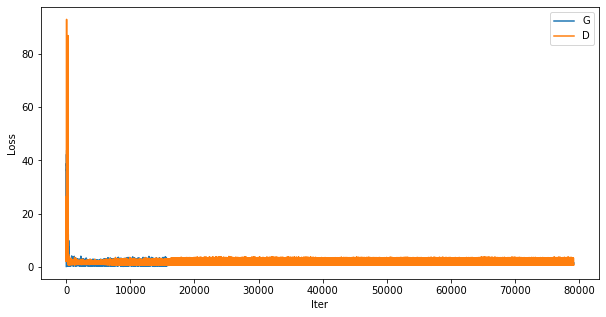

In [7]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

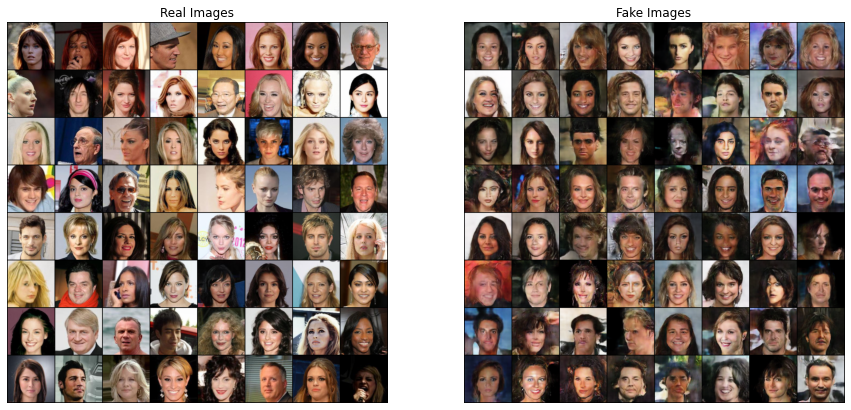

In [8]:
# check images
real_images = next(iter(train_dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(real_images[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Real Images")

plt.subplot(1,2,2)
fake_images = net_G(fixed_noise).detach().cpu()
fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
plt.imshow(fake_images)
plt.axis("off")
plt.title("Fake Images")
plt.show()